**Libraries**

In [1]:
# Import necessary libraries
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

**Transform**

In [2]:
# Define data transformations for training and testing datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

**Loading Data**

In [3]:
# Set up data directories
data_dir = 'C:/Users/LEGION/Downloads/Adıyaman-AD1 (Turkish side)-20240717T161401Z-001/Adıyaman-AD1 (Turkish side)/dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

**Initialize VGG-19**

In [4]:
# Load the pretrained VGG19 model and modify the classifier
model_ft = models.vgg19(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

# Set up device, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Train**

In [5]:
# Initialize variables for tracking losses and accuracies
losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}

# Train the model
num_epochs = 10
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        losses[phase].append(epoch_loss)
        accuracies[phase].append(epoch_acc.cpu().numpy())  # Move to CPU and convert to NumPy

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())

print(f'Best test Acc: {best_acc:.4f}')


Epoch 0/9
----------
train Loss: 1.1794 Acc: 0.3333
test Loss: 1.0306 Acc: 0.5000
Epoch 1/9
----------
train Loss: 1.0119 Acc: 0.4815
test Loss: 1.0040 Acc: 0.5000
Epoch 2/9
----------
train Loss: 0.8499 Acc: 0.7037
test Loss: 1.0208 Acc: 0.5000
Epoch 3/9
----------
train Loss: 0.7563 Acc: 0.6667
test Loss: 1.0660 Acc: 0.5000
Epoch 4/9
----------
train Loss: 0.7239 Acc: 0.7037
test Loss: 1.0889 Acc: 0.5000
Epoch 5/9
----------
train Loss: 0.6279 Acc: 0.7037
test Loss: 1.0671 Acc: 0.5000
Epoch 6/9
----------
train Loss: 0.6672 Acc: 0.6667
test Loss: 0.9935 Acc: 0.6667
Epoch 7/9
----------
train Loss: 0.5312 Acc: 0.7778
test Loss: 0.9015 Acc: 0.6667
Epoch 8/9
----------
train Loss: 0.4631 Acc: 0.7778
test Loss: 0.8216 Acc: 0.6667
Epoch 9/9
----------
train Loss: 0.4406 Acc: 0.7778
test Loss: 0.7642 Acc: 0.6667
Best test Acc: 0.6667


**Model Saving**

In [12]:
# Load the best model weights
model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict(), 'best_vgg19_model_son.pth')

RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 78040384 vs 78040272

**Grad-CAM**

In [7]:
# Define Grad-CAM implementation
def grad_cam(input_image, model, target_layer_names, class_idx=None):
    model.eval()
    features_blobs = []
    gradients = []

    def hook_feature(module, input, output):
        features_blobs.append(output.cpu().data.numpy())
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].cpu().data.numpy())
    
    model._modules.get(target_layer_names).register_forward_hook(hook_feature)
    model._modules.get(target_layer_names).register_backward_hook(backward_hook)
    
    output = model(input_image)
    if class_idx is None:
        class_idx = np.argmax(output.cpu().data.numpy())
    
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0][class_idx] = 1
    one_hot = torch.from_numpy(one_hot).to(device).requires_grad_(True)
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    grads_val = gradients[0]
    target = features_blobs[0]
    weights = np.mean(grads_val, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Predicted class: damage_type_a
True class: damage_type_a


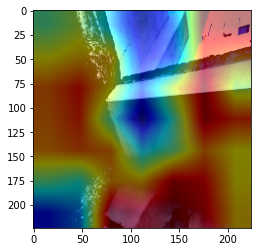

Predicted class: damage_type_a
True class: damage_type_c


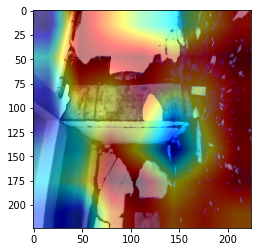

Predicted class: damage_type_a
True class: damage_type_a


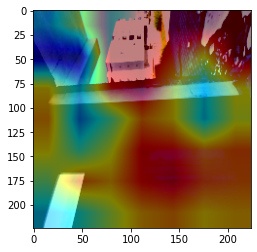

Predicted class: damage_type_a
True class: damage_type_a


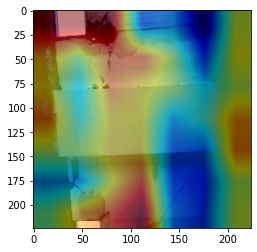

Predicted class: damage_type_a
True class: damage_type_c


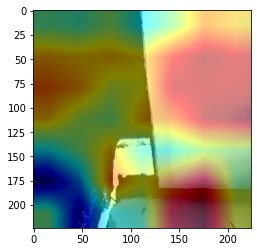

Predicted class: damage_type_b
True class: damage_type_b


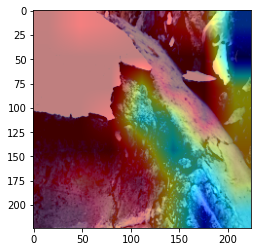

In [8]:
# Example of using Grad-CAM on test images
model_ft.eval()
inputs, classes = next(iter(dataloaders['test']))
inputs = inputs.to(device)
outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

for i in range(len(inputs)):
    input_img = inputs[i].unsqueeze(0)
    cam = grad_cam(input_img, model_ft, 'features', class_idx=preds[i])
    
    # Display the image and Grad-CAM
    img = input_img.cpu().data.numpy().squeeze().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)
    
    print(f'Predicted class: {class_names[preds[i]]}')
    print(f'True class: {class_names[classes[i]]}')
    
    plt.imshow(cam_img)
    plt.show()

**Loss and Accuracy**

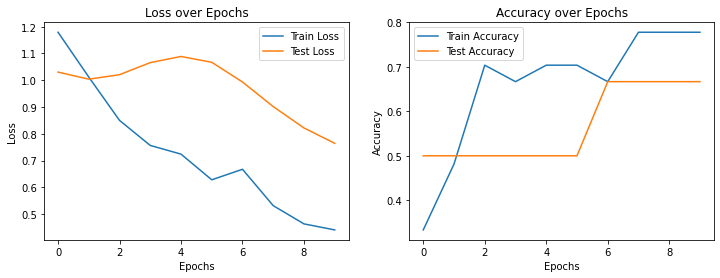

In [9]:
# Plotting losses and accuracies
epochs = range(num_epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses['train'], label='Train Loss')
plt.plot(epochs, losses['test'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies['train'], label='Train Accuracy')
plt.plot(epochs, accuracies['test'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

**Confussion Matrix**

c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


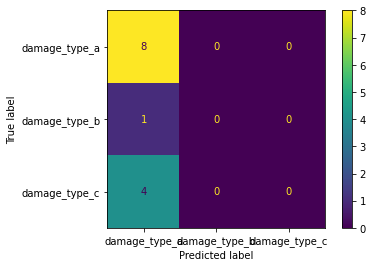

In [10]:
# Confusion Matrix and Classification Report
# Define the transform to preprocess the test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the test dataset
test_dir = "dataset/test"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model architecture and load the trained model state dictionary
model = models.vgg19(pretrained=False)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)
model.load_state_dict(torch.load('best_vgg19_model.pth'))
model.eval()
model.to(device)

# Lists to store true and predicted labels
y_test = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute the confusion matrix
y_test = np.array(y_test)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
labels = ["damage_type_a", "damage_type_b", "damage_type_c"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

**Classification Report**

In [11]:
# Print the classification report
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

damage_type_a       0.62      1.00      0.76         8
damage_type_b       0.00      0.00      0.00         1
damage_type_c       0.00      0.00      0.00         4

     accuracy                           0.62        13
    macro avg       0.21      0.33      0.25        13
 weighted avg       0.38      0.62      0.47        13



c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera